In [1]:
!pip install matplotlib
!pip install networkx
!pip install tsplib95
!pip install vrplib

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import tsplib95
import itertools as it
import random
import vrplib
import math
from operator import attrgetter
import time
import pandas as pd

In [3]:
def draw_graph(G):
    pos = {i: (data['x'], data['y']) for i, data in G.nodes(data=True)}
    plt.figure(figsize=(8, 6))    
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos)
    labels = {i: f'{i} (d={data["demand"]})' for i, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)
    plt.title("Cenário CVRP")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.grid(True)
    plt.show()

## CLASSES

In [4]:
### Função para calcular a distância entre dois nós
def euclidean_distance(node1, node2):
    x1, y1 = G.nodes[node1]['x'], G.nodes[node1]['y']
    x2, y2 = G.nodes[node2]['x'], G.nodes[node2]['y']
    
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_path_qualitity(G, path):
    qualitity = 0
    for i in range(len(path) - 1):
        node = path[i]
        next_node = path[i + 1]
        qualitity += euclidean_distance(node, next_node)
    # Soma do último cliente visitado para voltar ao depósito
    # qualitity += G[len(path) - 1][0][0]['weight']
    return qualitity

def calculate_demand_path(G, path):
    capacity = 0
    for node in path:
        capacity += G.nodes[node]['demand']
    return capacity

    
def get_best_team_qualitity(teams):
    best_team = None
    for team in teams:
        if best_team == None:
            best_team = team
        elif team.qualitity < best_team.qualitity:
            best_team = team
    return best_team

class Player:
    def __init__(self):
        self.path = []
        self.capacity = 0
        self.qualitity = 0

    def set_path(self, path):
        self.path = path
        
    def calcular_qualidade(self, G):
        self.qualitity = calculate_path_qualitity(G, self.path)
        return self.qualitity
        
class Team:
    def __init__(self):
        self.players = []
        self.captain = None
        self.qualitity = 0
        self.points = 0

    def add_player(self, player):
        self.players.append(player)

    def set_captain(self, player):
        self.captain = player

    def calcular_qualidade(self, G):
        self.qualitity = 0
        for index, player in enumerate(self.players):
            player_qualitity = player.calcular_qualidade(G)
            self.qualitity += player_qualitity
            if index == 0:
                self.captain = player
            elif player_qualitity < self.captain.qualitity:
                self.captain = player
        return self.qualitity

class Table:
    def __init__(self, teams):
        self.teams = teams

    def match(self, team_a, team_b):
        if team_a.qualitity < team_b.qualitity:
            team_a.points += 3
        elif team_b.qualitity < team_a.qualitity:
            team_b.points += 3
        else:
            team_a.points += 1
            team_b.points += 1
    
    def reset(self):
        for team in self.teams:
            team.points = 0

https://link.springer.com/article/10.1007/s10489-013-0512-y
<br>Formato padrão files: http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf

## Inicialização do grafo

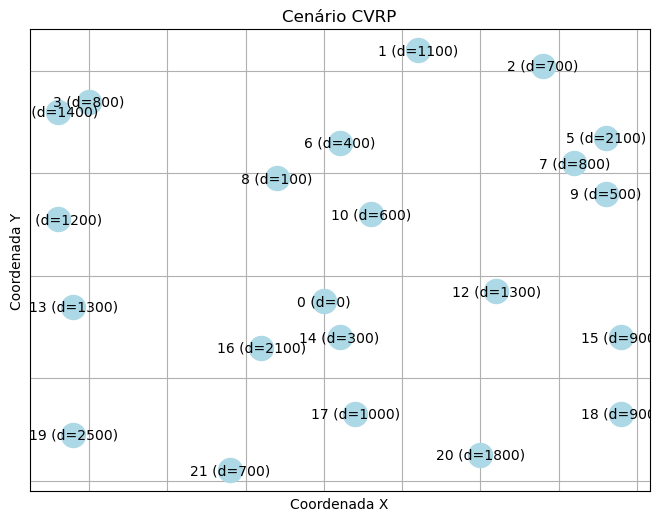

In [5]:
G = nx.MultiDiGraph()

instance = vrplib.read_instance("./Vrp-Set-E/E/E-n22-k4.vrp")
demand = instance['demand']
nodes_coords = instance['node_coord']
for i, (x, y) in enumerate(nodes_coords):
    G.add_node(i, x=int(x), y=int(y), demand=int(demand[i]))

G.edges(data=True)
draw_graph(G)

## Fase de Inicialização
Trabalho com técnica: https://ieeexplore.ieee.org/document/7550764
<br>
The first step is the creation of a set of solutions, called P,
which will make up the initial population. All solutions are
created randomly and they are called player (pi).

In [6]:
# Inicialização e divisão dos jogadores em times
def inicializar_solucoes(capacidade, quantidade_jogador, quantidade_time):
    teams = []
    for i in range(0, quantidade_time):
        team = Team()
        teams.append(team)
        nodes_available = list(G)
        nodes_available.pop(0) # Remoção do nodo depósito
        random.shuffle(nodes_available)
        for j in range(0, quantidade_jogador):
            if (len(nodes_available) == 0):
                break
            player = Player()
            team.add_player(player)
            path = [0]
            tries = 0
            while player.capacity < capacidade and len(nodes_available) > 0:
                node = nodes_available.pop(0)
                demand = G.nodes[node]['demand']
                if player.capacity + demand > capacidade:
                    tries += 1
                    nodes_available.append(node)
                    if tries == 2:
                        break
                    continue
                path.append(node)
                player.capacity += demand
            path.append(0)
            player.path = path
    return teams

# Visualização
# for index, team in enumerate(teams):
#     print(f"Time {index} | Qualidade {team.calculate_qualitity(G)} | Capitão {team.captain.qualitity}")
#     for player in team.players:
#         print(f"Jogador: {player.path} | Capacidade: {player.capacity} | Qualidade {player.qualitity}")

## Competição
### Funções

In [7]:
# Realiza a escolha aleatória de um elemento da lista com exceção do valor passado
def choice_excluding(lst, exceptions):
    possible_choices = [v for v in lst if v not in exceptions]
    return random.choice(possible_choices)
    
# Realiza a troca de forma randômica entre dois nodos de diferentes rotas
def swap_move(player_a, player_b, capacidade):

    if (len(player_a.path) < 4 or len(player_b.path) < 4):
        return False
        
    new_path_a = player_a.path[:]
    new_path_b = player_b.path[:]
    
    index_a = random.randint(1, len(new_path_a) - 2)
    index_b = random.randint(1, len(new_path_b) - 2)

    node_path_a = new_path_a[index_a]
    node_path_b = new_path_b[index_b]
    
    new_path_a[index_a] = node_path_b
    new_path_b[index_b] = node_path_a

    demand_node_a = G.nodes[node_path_a]['demand']
    demand_node_b = G.nodes[node_path_b]['demand']
    new_demand_a = (player_a.capacity - demand_node_a) + demand_node_b
    new_demand_b = (player_b.capacity - demand_node_b) + demand_node_a

    if new_demand_a > capacidade or new_demand_b > capacidade:
        return False

    qualitity_path_a = calculate_path_qualitity(G, new_path_a)
    qualitity_path_b = calculate_path_qualitity(G, new_path_b)
    if qualitity_path_a < player_a.qualitity and qualitity_path_b < player_b.qualitity:
        player_a.path = new_path_a
        player_a.capacity = new_demand_a
        player_b.path = new_path_b
        player_b.capacity = new_demand_b
        # if len(player_a.path) == 2 or len(player_b.path) == 2:
        #     print("Swap move")
        return True
    return False

# Realiza a troca de forma randômica entre dois nodos de uma mesma rota
def shift_move(player):
    new_path = player.path[:]

    if len(new_path) > 3:
        idx1, idx2 = random.sample(range(1, len(new_path) - 1), 2)
        new_path[idx1], new_path[idx2] = new_path[idx2], new_path[idx1]
        qualitity_path = calculate_path_qualitity(G, new_path)
        if qualitity_path > player.qualitity:
            return False
        player.path = new_path
        return True
    return False
    


In [8]:

# Partidas entre os times
def realiza_partidas(teams, table):
    for i, team in enumerate(teams):
        for j in range(i+1, len(teams)):
            table.match(team, teams[j])

def sort_teams_by_points(teams):
    return sorted(teams, key=attrgetter('points'), reverse=True)

def sort_players_by_qualitity(players):
    return sorted(players, key=attrgetter('qualitity'))

def transferencia_times(teams, capacidade):
    teams_ordered = sort_teams_by_points(teams)
    for i in range(int(len(teams_ordered) - 1)):
        team_a = teams_ordered[i]
        team_b = teams_ordered[i + 1]
        team_a_players_ordered = sort_players_by_qualitity(team_a.players)
        team_b_players_ordered = sort_players_by_qualitity(team_b.players)
        team_a_worse_player = team_a_players_ordered[-1]
        team_b_best_player = team_b_players_ordered[0]
        team_a_qualitity = team_a.qualitity

        # Guarda os paths dos players do time A
        team_a_original_paths = [player.path[:] for player in team_a.players]
        
        # Verificar valores diferentes entre o worse e best player
        different_values_path = [node for node in team_a_worse_player.path if node not in team_b_best_player.path]

        # print("===========")
        # print("Team A worse: ", team_a_worse_player.path)
        # Troca path do pior time A para ser igual ao do melhor time B.
        team_a_worse_player.path = team_b_best_player.path
        # team_a_worse_player.capacity = team_b_best_player.capacity
        
        # Ajuste nos paths dos outros jogadores para não repetir valores
        for player in team_a.players:
            if len(different_values_path) > 0:
                # Não é o mesmo player
                if player != team_a_worse_player:
                    player.path = [node for node in player.path if node == 0 or node not in team_a_worse_player.path]
                    player.path = [different_values_path.pop(0) if node in team_a_worse_player.path and node != 0 and len(different_values_path) > 0 and different_values_path[0] not in player.path else node for node in player.path]


        
       # Lógica para adicionar valores restantes em players respeitando a demanda dos nodos
        if len(different_values_path) > 0:
            for player in team_a.players:
                if player != team_a_worse_player:
                    # capacity = calculate_demand_path(G, player.path)
                    capacity = player.capacity
                    while capacity < capacidade and len(different_values_path) > 0:
                        node = different_values_path[0]
                        node_demand = G.nodes[node]['demand']
                        # Verificar se o nodo já não está no path (não repetir valores)
                        if node in player.path:
                            different_values_path.pop(0)
                            continue
                        if (capacity + node_demand) > capacidade:
                            break
                        # Escolher um índice aleatório entre o segundo e penúltimo para inserir o novo nodo
                        random_index = random.randint(1, len(player.path) - 1)
                        player.path.insert(random_index, node)
                        different_values_path.pop(0)
                        capacity += node_demand
                        # player.capacity = capacity
                    player.capacity = capacity

        # Se ainda sobrou, adicionar no novo path do team A.
        if len(different_values_path) > 0:
            capacity = calculate_demand_path(G, team_a_worse_player.path)
            while capacity < capacidade and len(different_values_path) > 0:
                node = different_values_path[0]
                node_demand = G.nodes[node]['demand']
                if (capacity + node_demand) > capacidade:
                    break
                # Escolher um índice aleatório entre o segundo e penúltimo para inserir o novo nodo
                random_index = random.randint(1, len(team_a_worse_player.path) - 1)
                team_a_worse_player.path.insert(random_index, node)
                different_values_path.pop(0)
                capacity += node_demand
            team_a_worse_player.capacity = capacity

        sum_new_qualitity = 0
        delete_player = False
        for player in team_a.players:
            # Se um path deixou de existir elimina esse player
            if len(player.path) == 2:
                delete_player = True
            sum_new_qualitity += player.calcular_qualidade(G)

        # Verificar (Criar um novo veículo - provavelmente.) - Alterar no pop do time original (leva em consideração q não aumentou carros)
        forceBack = len(different_values_path) > 0
        
        # Se o time tiver piorado, retorna para os paths anteriores dos players
        if sum_new_qualitity > team_a_qualitity or forceBack == True:
            for player in team_a.players: 
                player.path = team_a_original_paths.pop(0)
                player.calcular_qualidade(G)
        elif delete_player:
            team_a.players = [player for player in team_a.players if len(player.path) > 2]


In [9]:
def golden_ball(capacidade, quantidade_jogador, quantidade_time, max_iteracoes):
    times = inicializar_solucoes(capacidade, quantidade_jogador, quantidade_time)
    for time in times:
        time.calcular_qualidade(G)
    tabela = Table(times)
        
    for i in range(max_iteracoes):
        tabela.reset()
        for time in times:
            jogador_a, jogador_b = random.sample(time.players, 2)
            if swap_move(jogador_a, jogador_b, capacidade):
                time.calcular_qualidade(G)
            jogador = random.choice(time.players)
            if shift_move(jogador):
                time.calcular_qualidade(G)
                
        realiza_partidas(times, tabela)
        transferencia_times(times, capacidade)
        
    return times

In [10]:
capacidade = 6000
quantidade_jogador = 10
quantidade_time = 30
iteracoes = 2000

times_melhorados = golden_ball(capacidade, quantidade_jogador, quantidade_time, iteracoes)
new_best_team = get_best_team_qualitity(times_melhorados)
print("Melhor time depois do algoritmo: ", new_best_team.qualitity)
for player in new_best_team.players:
    print(player.path)
    print(player.capacity)

Melhor time depois do algoritmo:  482.32271129816246
[0, 16, 13, 11, 4, 6, 9, 0]
5700
[0, 10, 15, 20, 19, 0]
5800
[0, 8, 3, 1, 2, 5, 7, 0]
5600
[0, 12, 18, 21, 17, 14, 0]
5200


In [11]:
def testar_parametros(combinacoes_parametros, G, capacidade, num_testes):
    resultados = []

    for quantidade_time, max_iteracoes in combinacoes_parametros:
        custos = []
        tempos = []
        melhores_times = []

        for _ in range(num_testes):
            inicio = time.time()
            times_melhorados = golden_ball(capacidade, 10, quantidade_time, max_iteracoes)
            fim = time.time()

            best_team = get_best_team_qualitity(times_melhorados)
            custos.append(best_team.qualitity)
            tempos.append((fim - inicio) * 1000)
            melhores_times.append(best_team)

        media_custos = sum(custos) / num_testes
        melhor_custo_global = min(custos)
        media_tempo = sum(tempos) / num_testes

        # Captura o melhor time global
        melhor_time_global = melhores_times[custos.index(melhor_custo_global)]

        resultados.append({
            'Número de times': quantidade_time,
            'Máximo de iterações': max_iteracoes,
            'Média dos custos': media_custos,
            'Melhor custo': melhor_custo_global,
            'Média do tempo (ms)': media_tempo,
            'Melhor time (caminho)': [player.path for player in melhor_time_global.players],
        })
        
        print(f"Parâmetros: Times={quantidade_time}, Iterações={max_iteracoes} -> Média Custo: {media_custos:.2f}, Melhor Custo: {melhor_custo_global:.2f}, Média Tempo: {media_tempo:.2f} ms")
        print(f"Melhor time global (caminhos): {[player.path for player in melhor_time_global.players]}")

    return resultados


In [ ]:
# quantidade_times = [2]
# max_iteracoes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]

quantidade_times = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
max_iteracoes = [1000, 2000, 3000, 4000]

combinacoes_parametros = list(it.product(quantidade_times, max_iteracoes))

# Executando o teste
resultados = testar_parametros(combinacoes_parametros, G, 6000, 10)

df_resultados = pd.DataFrame(resultados)
print(df_resultados.sort_values(by='Média dos custos').head(10))

Parâmetros: Times=2, Iterações=1000 -> Média Custo: 595.59, Melhor Custo: 535.28, Média Tempo: 187.11 ms
Melhor time global (caminhos): [[0, 14, 16, 8, 4, 2, 7, 9, 0], [0, 12, 15, 5, 1, 10, 0], [0, 17, 21, 19, 13, 0], [0, 11, 3, 6, 18, 20, 0]]
Parâmetros: Times=2, Iterações=2000 -> Média Custo: 549.67, Melhor Custo: 442.80, Média Tempo: 193.60 ms
Melhor time global (caminhos): [[0, 16, 8, 6, 5, 7, 9, 0], [0, 19, 21, 20, 17, 14, 0], [0, 12, 15, 18, 13, 11, 0], [0, 10, 2, 1, 3, 4, 0]]
Parâmetros: Times=2, Iterações=3000 -> Média Custo: 581.56, Melhor Custo: 535.80, Média Tempo: 552.50 ms
Melhor time global (caminhos): [[0, 4, 3, 6, 5, 7, 9, 0], [0, 11, 19, 20, 14, 0], [0, 10, 2, 1, 6, 8, 13, 21, 17, 0], [0, 16, 18, 15, 12, 8, 8, 0]]
Parâmetros: Times=2, Iterações=4000 -> Média Custo: 530.58, Melhor Custo: 427.77, Média Tempo: 481.92 ms
Melhor time global (caminhos): [[0, 9, 7, 5, 6, 8, 10, 13, 0], [0, 11, 4, 3, 1, 2, 14, 0], [0, 21, 20, 18, 15, 12, 0], [0, 17, 19, 16, 0]]
Parâmetros: Tim

In [ ]:
df_resultados = pd.DataFrame(resultados)
print(df_resultados.sort_values(by='Média dos custos').head(10))

In [ ]:
rotas = [[0, 11, 4, 3, 8, 6, 7, 9, 14, 0], [0, 13, 16, 21, 20, 0], [0, 19, 17, 18, 15, 14, 0], [0, 10, 1, 2, 5, 12, 0]]

for rota in rotas:
    acc = 0
    for nodo in rota:
        acc += G.nodes[nodo]['demand']
    print("Capacidade: ", acc)
    acc = 0

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_resultados,
    x='Número de times',
    y='Média dos custos',
    marker='o',
    label='Média dos Custos'
)

plt.title('Número de times X Média dos custos', fontsize=14)
plt.xlabel('Número de times', fontsize=12)
plt.ylabel('Média dos custos', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_resultados,
    x='Máximo de iterações',
    y='Média dos custos',
    marker='o',
    label='Média dos Custos'
)

plt.title('Número de iterações X Média dos custos', fontsize=14)
plt.xlabel('Número de iterações', fontsize=12)
plt.ylabel('Média dos custos', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Route #1: 17 20 18 15 12 
# Route #2: 16 19 21 14 
# Route #3: 13 11 4 3 8 10 
# Route #4: 9 7 5 2 1 6 
# Cost 375

path1 = [0, 17, 20, 18, 15, 12, 0]
path2 = [0, 16, 19, 21, 14, 0]
path3 = [0, 13, 11, 4, 3, 8, 10, 0]
path4 = [0, 9, 7, 5, 2, 1, 6, 0]

val1 = calculate_path_qualitity(G, path1)
val2 = calculate_path_qualitity(G, path2)
val3 = calculate_path_qualitity(G, path3)
val4 = calculate_path_qualitity(G, path4)
print(val1+val2+val3+val4)
